In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random
from skimage.transform import resize
from tqdm import tqdm
import imageio.v3 as iio
import matplotlib.patches as patches
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from io import BytesIO 
import tensorflow as tf
from tensorflow.keras import layers, Model

2024-03-21 11:28:03.696470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 11:28:03.696510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 11:28:03.697950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 11:28:03.705956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 11:28:04.702021: W tensorflow/compiler/tf2

In [2]:
# video config
WIDTH = 25
HEIGHT = 25
DIM = 3
X_DIM = 3

WIDTH_FACTOR = 800 // WIDTH
HEIGHT_FACTOR = 600 // HEIGHT

In [3]:
def draw_bounding_boxes_from_array(video_path, bounding_boxes, output_video_path):

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create a VideoWriter object for AVI format
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if frame_count < len(bounding_boxes):
            x, y = bounding_boxes[frame_count]
            x, y = int(x), int(y)
            width, height = 30, 30 

            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)

        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()

    print(f"Bounding boxes added and new video saved to: {output_video_path}")

def read_png_image(file_path, i):

    file_name = os.path.basename(file_path)
    image_array = random_augment(file_path)
    image_array = resize(image_array, (WIDTH , HEIGHT), anti_aliasing=True)

    # Remove alpha channel
    #image_array = np.flipud(image_array[:,:,:3])

    number = int(file_name.split("_")[1].split(".")[0])

    df = pd.read_csv(f'assets/preprocessed_bb_coordinates/moving_circle_{i}.csv')
    x = df['X-coordinate']
    y = df['Y-coordinate']

    return image_array/255.0, x[number]//WIDTH_FACTOR, y[number]//HEIGHT_FACTOR

def plot_image(img, bb, save_path):

    fig, ax = plt.subplots()

    plt.imshow(img)
    x, y = (bb[0]-30)//WIDTH_FACTOR, (bb[1]-30)//HEIGHT_FACTOR
    rect = patches.Rectangle((x, y), 10, 10, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.savefig(save_path)
    plt.close()

def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.08, 0.08), "y":(-0.08, 0.08)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

def random_augment(image):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)

  return image

## Preprocess data

Text(0.5, 1.0, 'Zoomed Image')

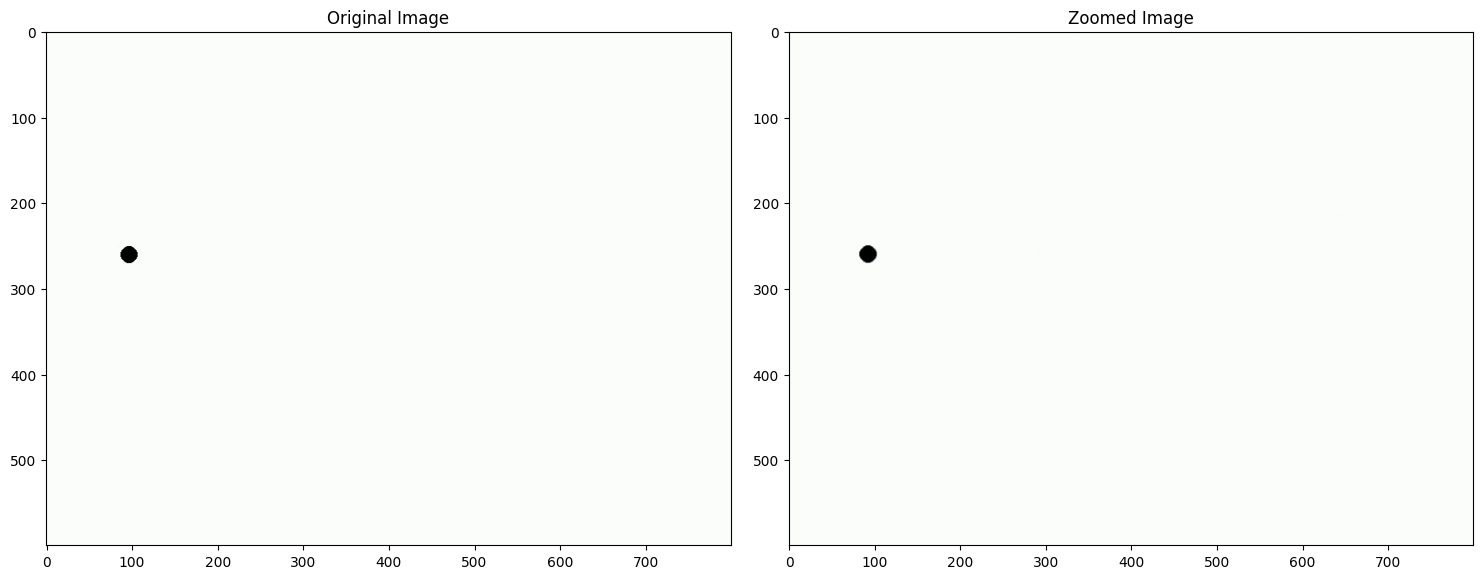

In [4]:
#image = image_paths[random.randint(0, 35)]
image = 'assets/original_frames/moving_circle_0/frame_0020.png'
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

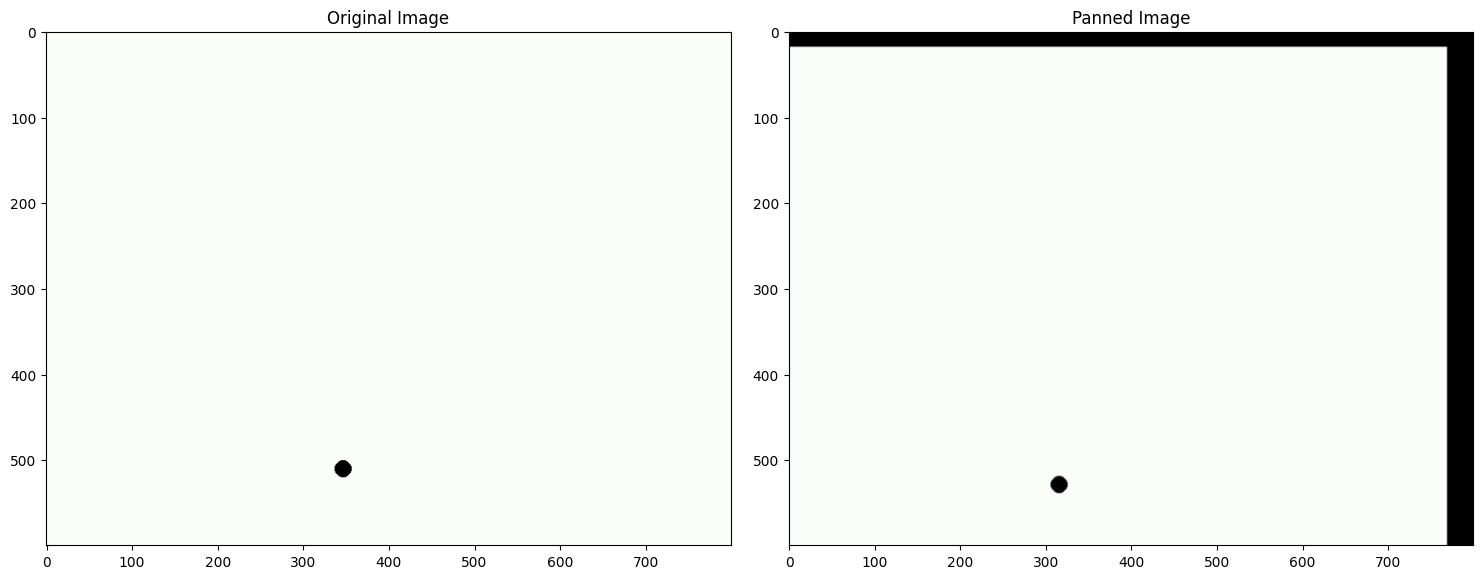

In [5]:
image = 'assets/original_frames/moving_circle_0/frame_0070.png'
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'brightness Altered Image')

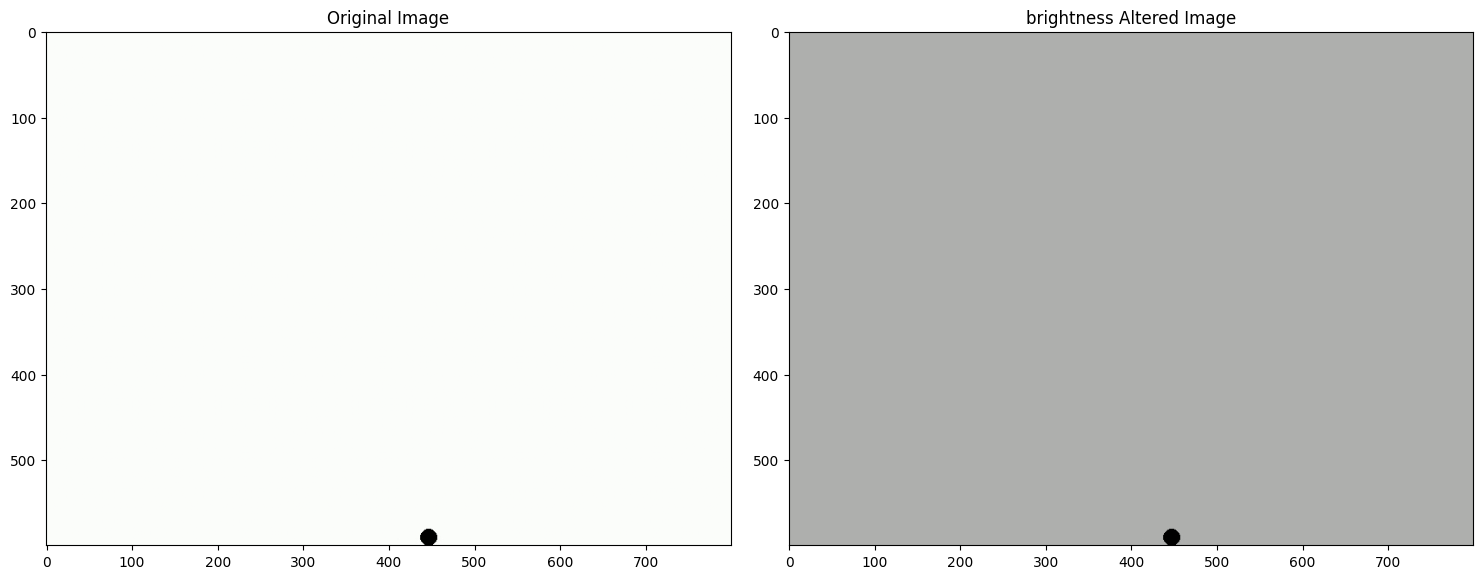

In [6]:
image = 'assets/original_frames/moving_circle_0/frame_0090.png'
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness Altered Image')

## Load Data

In [7]:
# find all png files
#shapes = {'circle':4, 'rect':3, 'star':4}
shapes = {'circle':15}
X, y_bb = [], []
for j in shapes.keys():
    for i in tqdm(range(shapes[j]), desc='Preprocessing images...'):
        img_path = os.path.join(os.getcwd(), f'assets/original_frames/moving_{j}_{i}')
        files = glob.glob(os.path.join(img_path, '*.png'))
        sorted_files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

        for filepath in sorted_files:
            image_array, x, y = read_png_image(filepath, i)

            X.append(image_array)
            y_bb.append([x, y])
print('Preprocessing done!\n')

Preprocessing images...: 100%|██████████| 15/15 [25:27<00:00, 101.84s/it]

Preprocessing done!



In [8]:
X, y_bb = np.array(X), np.array(y_bb)

scaler = MinMaxScaler()
scaled_bb = scaler.fit_transform(y_bb)
#scaled_bb = y_bb

print(f'shape of X: {X.shape}, shape of y_bb:{y_bb.shape}')

shape of X: (10200, 25, 25, 3), shape of y_bb:(10200, 2)


In [9]:
# data splitting
n_samples = len(X)
train_idx = int(n_samples * 0.98)
X_train, X_test = X[:train_idx,...], X[train_idx:, ...]
y_bb_train, y_bb_test = scaled_bb[:train_idx], scaled_bb[train_idx:]

Text(0.5, 1.0, 'Validation set')

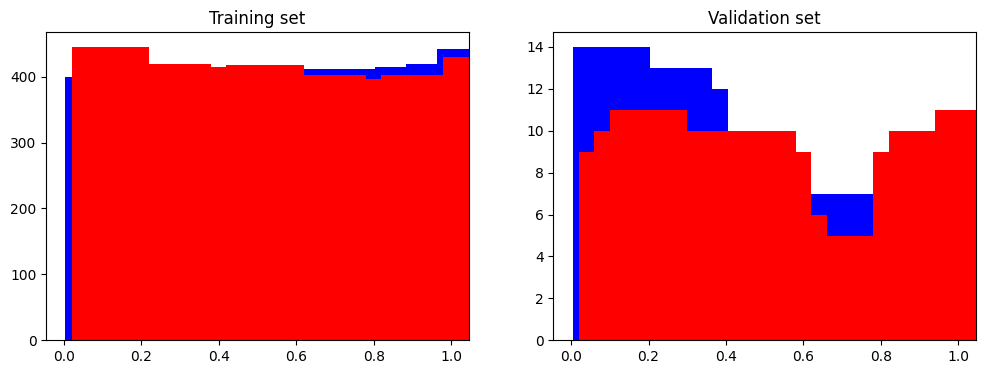

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_bb_train, bins=25, width=0.2, color=['blue', 'red'])
axes[0].set_title('Training set')

axes[1].hist(y_bb_test, bins=25, width=0.2, color=['blue', 'red'])
axes[1].set_title('Validation set')

## Training

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy, \
                                    mean_squared_error, categorical_crossentropy

In [15]:
def LocalizeAlexNet():

    input = layers.Input((WIDTH, HEIGHT, DIM))

    # first conv layer
    x = Conv2D(filters=16, kernel_size=5, strides=(4, 4), activation='relu', padding='same')(input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=1, strides=(2, 2))(x)

    # second conv layer
    x = Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=1, strides=(2, 2))(x)

    # second conv layer
    x = Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=1, strides=(2, 2))(x)

    x = Flatten()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # bounding box
    output_bb = Dense(2, activation='linear', name='output_bb')(x)

    return Model(inputs=input, outputs=[output_bb])


In [16]:
model = LocalizeAlexNet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25, 25, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          1216      
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 16)          64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 batch_normalization_4 (Bat  (None, 4, 4, 32)          128   

In [17]:
combined_loss = {
    'output_bb': mean_squared_error
}

loss_weights = {
    'output_bb': 0.1, 
}


model.compile(optimizer='adam',
              loss=combined_loss,
                loss_weights=loss_weights,
              )

In [18]:
steps_per_epoch = len(X_train) // 64
history = model.fit(X_train, [y_bb_train],
                    epochs=110,
                    batch_size=64,
                    validation_data=(X_test, [y_bb_test]),
                    steps_per_epoch=steps_per_epoch,
                    shuffle=True)

print(history.history.keys())

Epoch 1/110


2024-03-21 11:54:59.185056: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-21 11:54:59.278765: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 11:54:59.494864: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 11:55:00.590470: I external/local_xla/xla/service/service.cc:168] XLA service 0x737e0c39d540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 11:55:00.590528: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2024-03-21 11:55:00.607546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711018500.733971   14164 device_compiler.h:186] Compile

156/156 [==============================] - 6s 10ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 2/110
156/156 [==============================] - 1s 8ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 3/110
156/156 [==============================] - 1s 8ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 4/110
156/156 [==============================] - 1s 8ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 5/110
156/156 [==============================] - 1s 8ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 6/110
156/156 [==============================] - 1s 8ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 7/110
156/156 [==============================] - 1s 7ms/step - loss: 0.0087 - val_loss: 0.0095
Epoch 8/110
156/156 [==============================] - 1s 8ms/step - loss: 0.0087 - val_loss: 0.0097
Epoch 9/110
156/156 [==============================] - 1s 8ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 10/110
156/156 [==============================] - 1s 7ms/step - loss: 0.0085 - val_loss: 0.0098


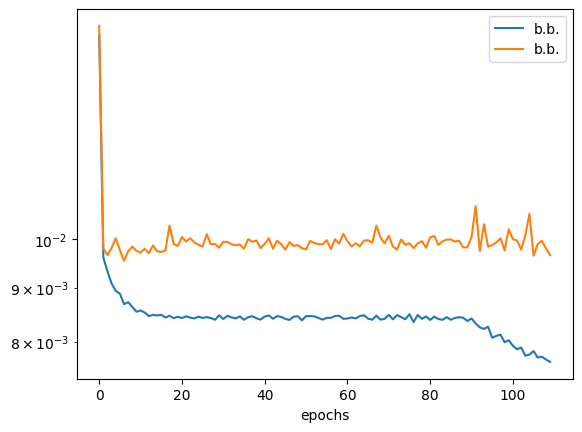

In [19]:
fig = plt.figure()
plt.plot(history.history['loss'], label='b.b.')
plt.plot(history.history['val_loss'], label='b.b.')
plt.legend()
plt.yscale('log')
plt.xlabel('epochs')
plt.savefig('loss_curves.png')

## Inference

In [20]:
video_directory = '/home/mehdi/Desktop/object_tracking/assets/original_val_videos/moving_circle_3.mp4'
output_video_path = 'moving_circle_val_inference_test_0.mp4'

cap = cv2.VideoCapture(video_directory)
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    with BytesIO() as f:
        iio.imwrite(f, frame, format='png')
        f.seek(0)
        image_array = iio.imread(f)

    # Resize the image
    image_array = resize(image_array, (WIDTH, HEIGHT), anti_aliasing=True)
    frames.append(image_array/255.0)

frames = np.array(frames)
frames = frames.reshape(frames.shape[0], WIDTH, HEIGHT, 3)

predictions = model.predict(frames)
bb = scaler.inverse_transform(predictions)
#bb = predictions

for i in range(len(bb)):
    bb[i][0] = int(abs(bb[i][0]) * WIDTH_FACTOR)
    bb[i][1] = int(abs(bb[i][1]) * HEIGHT_FACTOR)
print(bb)

cap.release()

draw_bounding_boxes_from_array(video_directory, bb, output_video_path)

/home/mehdi/Desktop/object_tracking/object_tracking/lib/python3.10/site-packages/imageio/plugins/pillow.py:125: UserWarning: Can't determine file format to write as. You _must_ set `format` during write or the call will fail. Use `extension` to supress this warning. 
  warnings.warn(


29/29 [==============================] - 0s 7ms/step
[[387. 277.]
 [387. 277.]
 [387. 277.]
 ...
 [387. 277.]
 [387. 277.]
 [387. 277.]]


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Bounding boxes added and new video saved to: moving_circle_val_inference_test_0.mp4


In [ ]:
model.save('models/model_cnn_0.h5')

In [ ]:
from keras.models import load_model
loaded_model = load_model('model_3.h5')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
def img_preprocess_2(img):
  #img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.medianBlur(img, 5)
  img = cv2.resize(img, (1600, 750))
  return img

In [ ]:
image = image_paths[random.randint(0, 0)]
original_image = mpimg.imread(image)
original_image = np.asarray(original_image)
p_image = img_preprocess_2(original_image)
p_image.shape

In [ ]:
image = image_paths[random.randint(0, 30)]
image = mpimg.imread(image)
#image = np.asarray(original_image)
image = img_preprocess_2(image)
#image = image.resize((750, 1600))
image = np.expand_dims(np.array(image), axis=0)
#image = np.array([original_image])
predicted_array = []
print(f'The image size is {image.shape}')
predicted_array = loaded_model.predict(image)


In [ ]:
print(predicted_array)

In [ ]:
import cv2
image = image_paths[6]
image = mpimg.imread(image)
image = img_preprocess_2(image)
x_coord = int(predicted_array[0][0]*750)
y_coord = int(predicted_array[0][1]*1600)
width = 100
height = 100
temp1 = x_coord + 90
temp2 = y_coord + 90
top_left = (x_coord-90, y_coord-90)
bottom_right = (temp1, temp2)

color = (0, 255, 0)
thickness = 2
cv2.rectangle(image, top_left, bottom_right, color, thickness)

#cv2.imshow("image with bound box: ", image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
#fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title(' Image with bound box')
cv2.waitKey(0)
cv2.destroyAllWindows()